In [4]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5 # reverse normalization   
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

100%|██████████████████████████████████████| 26.4M/26.4M [00:03<00:00, 7.20MB/s]
100%|███████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 181kB/s]
100%|██████████████████████████████████████| 4.42M/4.42M [00:01<00:00, 3.36MB/s]
100%|██████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 9.40MB/s]


In [5]:
# 定义模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
# 定义损失和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Tensorboard

### Add images

In [17]:
dataiter = iter(trainloader)
images, label = next(dataiter)

In [18]:
images

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ...,

In [19]:
#torchvision's make_grid can merge multiple images into one
img_grid = torchvision.utils.make_grid(images)
img_grid.shape

torch.Size([3, 32, 122])

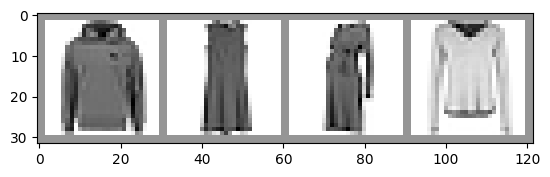

In [20]:
matplotlib_imshow(img_grid, one_channel=True)

In [14]:
from torch.utils.tensorboard import SummaryWriter

In [15]:
#new directory and file will be created
writer = SummaryWriter('run/fashion_mnist_experiment_1')

In [16]:
writer.add_image('four_fashipn_mnist_images', img_grid)

#### Open terminal, change to the environment and the directory with the run folder, then execute:
`tensorboard --logdir=run`

Open the result local url, e.g. http://localhost:6006/

In [21]:
images2, label2 = next(dataiter)

In [22]:
img_grid = torchvision.utils.make_grid(images2)
writer.add_image('four_fashipn_mnist_images2', img_grid)

In [23]:
images3, label3 = next(dataiter)
img_grid = torchvision.utils.make_grid(images3)
writer.add_image('four_fashipn_mnist_images3', img_grid)

### Add model structure

In [24]:
writer.add_graph(net, images)

#### There will be a new tab generated in Tensorboard 'Graph', showing the structure of the model.

### Add the change of loss

In [26]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            running_loss = 0.0
print('Finished Training')

Finished Training


#### There will be a new tab generated in Tensorboard 'Scalar', showing the loss of the model calculated above.